In [199]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import random as rn
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from models import encoder,decoder,discriminator

In [200]:
#Constants
SEED = 42

In [201]:
cur = os.getcwd()
db = pd.read_csv(os.path.join(cur,'../outputs/megasample_cleaned.csv'))

In [202]:
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

# Data Preparation from DataFrame

In [203]:
cat_list = db.columns.tolist()
print(len(cat_list))

447


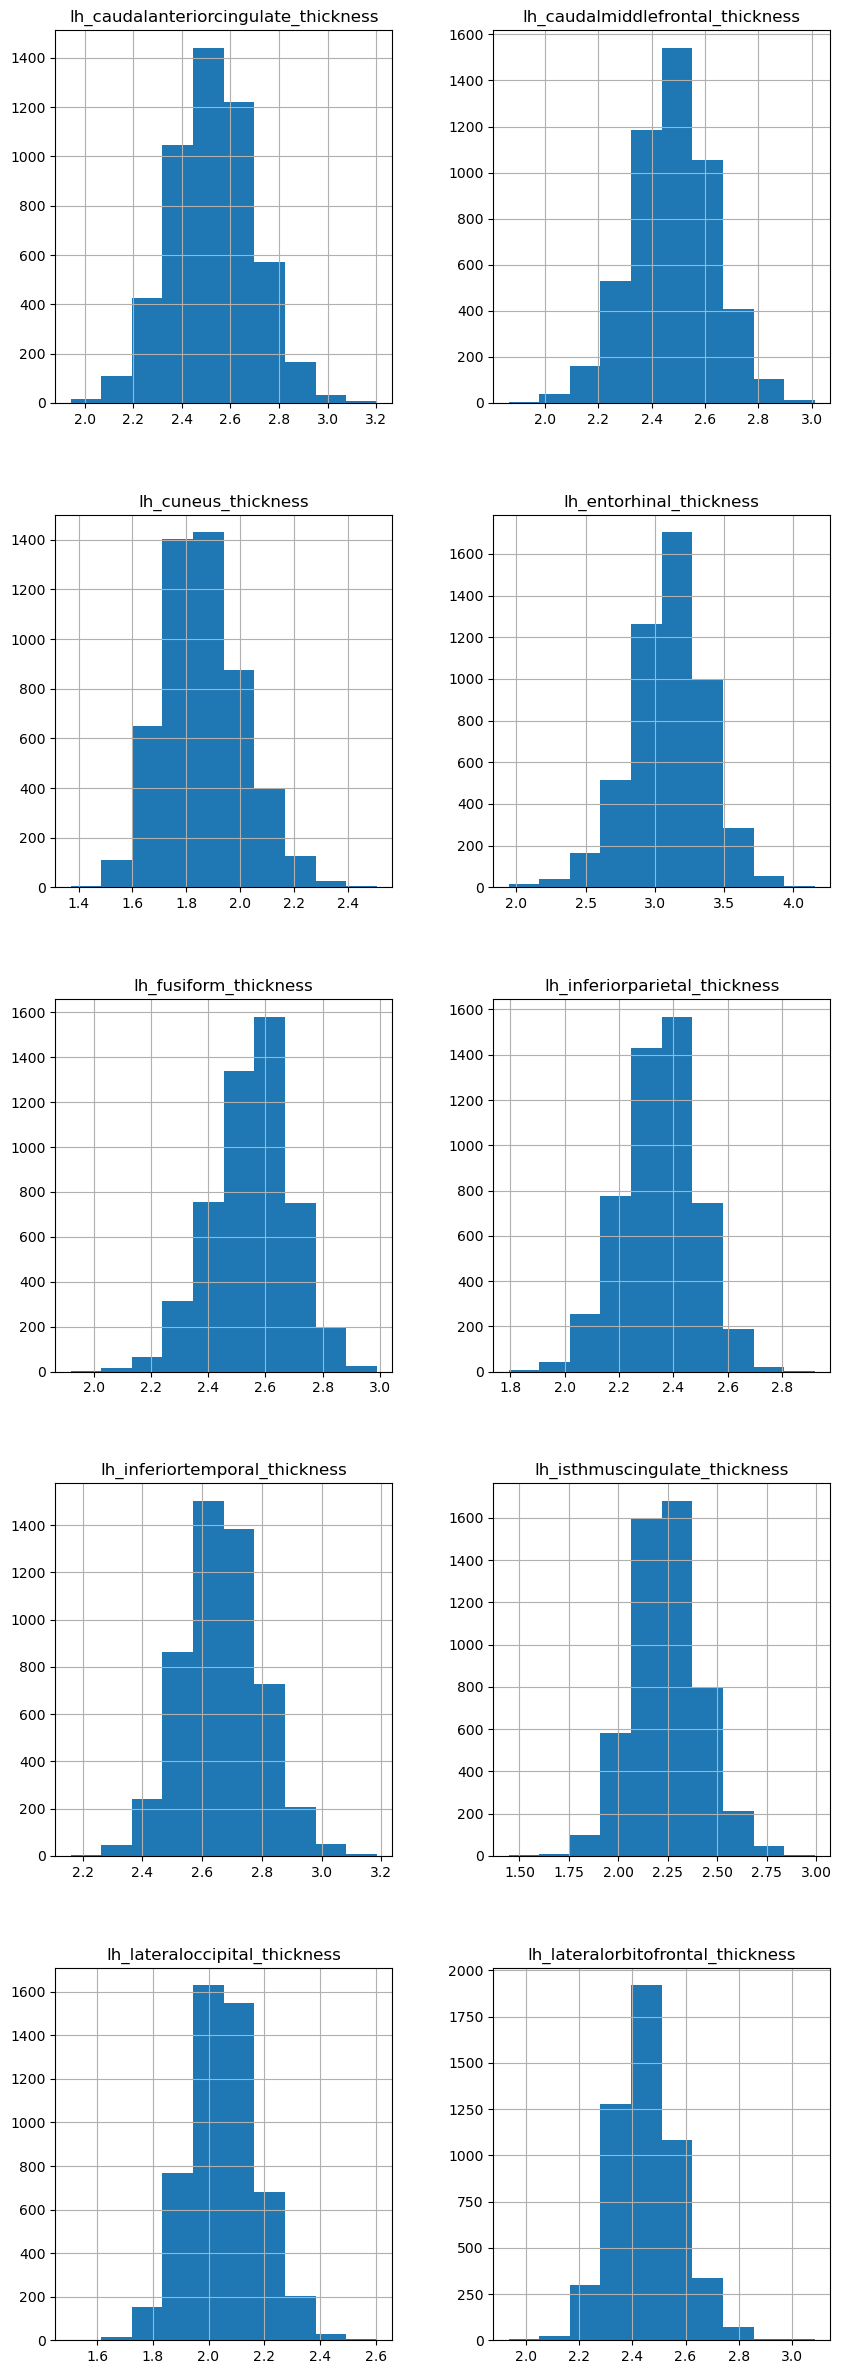

In [204]:
x_data = db.drop(['age', 'sex', 'scanner', 'euler', 'BrainSegVolNotVent', 'euler_med', 'sample', 'dcode', 'timepoint'],axis=1,inplace=False)
x_data.iloc[:,:10].hist(figsize=(10,30),layout=(5,2));

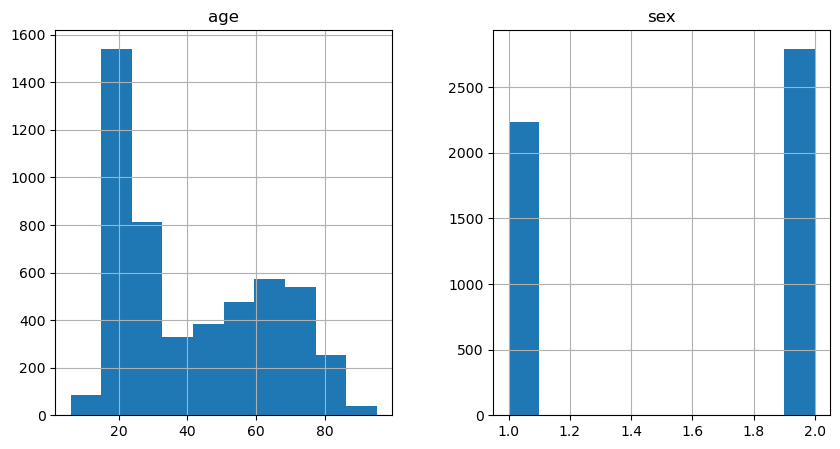

In [205]:
db.loc[:,['age','sex']].hist(figsize=(10,5),layout=(1,2));

## Data Normalization

In [206]:
total_brain_vol = db['BrainSegVolNotVent']
scaler = RobustScaler()
x_data_norm = scaler.fit_transform(x_data)

## Encoding Codependent Variables

In [207]:
ohe = OneHotEncoder(sparse=False)
one_hot_sex = ohe.fit_transform(db['sex'].values[:, np.newaxis].astype('float32'))

age = db[['age']].round(0)
age.groupby('age',dropna=False)['age'].count()
one_hot_age = ohe.fit_transform(age['age'].values[:, np.newaxis].astype('float32'))

y_data = np.concatenate((one_hot_age, one_hot_sex), axis=1).astype('float32')

In [208]:
# Create the dataset iterator
batch_size = 256
n_samples = x_data.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((x_data_norm, y_data))
train_dataset = train_dataset.shuffle(buffer_size=n_samples)
train_dataset = train_dataset.batch(batch_size)

# Model Creation

In [209]:
n_features = x_data_norm.shape[1]
n_labels = y_data.shape[1]
h_dim = [200,200]
z_dim = 60

In [210]:
encoder = encoder(n_features, h_dim, z_dim)
decoder = decoder(z_dim + n_labels, n_features, h_dim)
discriminator = discriminator(z_dim, h_dim)